## Get the Data

In [87]:
import pandas as pd

df = pd.read_csv("../Data/cleaned_dataset.csv")
df

,Mean Temperature,Mean Pressure,Rainfall,Relative Humidity,Mean Cloud,Evaporation,Global Solar Radiation,Max UV,Wind Speed,Mean UV,...,RSP,O3,FSP,Intensity,Signal,Duration(hr min),day_sin,day_cos,wind_sin,wind_cos
0,15.4,1025.1,0.00,68.0,57.0,3.4,18.11,10.072187,6.730814,4.592663,...,43.0,0.0,31.0,0.0,0.0,0.0,0.999991,0.004304,0.173648,0.984808
1,16.6,1025.8,0.00,69.0,79.0,3.1,12.94,9.279723,8.470005,3.780165,...,57.0,0.0,37.0,0.0,0.0,0.0,0.999917,-0.012910,0.173648,0.984808
2,17.5,1023.0,0.00,69.0,53.0,4.0,20.32,10.851292,6.246643,5.183114,...,51.0,0.0,37.0,0.0,0.0,0.0,0.999546,-0.030120,0.173648,0.984808
3,18.5,1018.7,0.00,78.0,89.0,2.8,12.21,11.371977,10.663324,4.197858,...,53.0,-0.0,33.0,0.0,0.0,0.0,0.998880,-0.047321,0.342020,0.939693
4,19.7,1014.7,0.05,85.0,90.0,1.6,11.50,10.239657,11.126056,3.814848,...,54.0,-0.0,33.0,0.0,0.0,0.0,0.997917,-0.064508,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157,27.3,1009.3,0.05,73.0,77.0,3.1,9.52,4.000000,12.200000,2.000000,...,24.0,65.0,18.0,0.0,0.0,0.0,-0.891981,0.452072,0.984808,-0.173648
12158,25.8,1010.1,0.05,67.0,83.0,3.0,6.97,4.000000,9.700000,2.000000,...,16.0,28.0,11.0,0.0,0.0,0.0,-0.884068,0.467359,0.500000,0.866025
12159,25.3,1011.1,0.05,69.0,86.0,3.0,9.41,6.000000,8.400000,2.000000,...,19.0,31.0,14.0,0.0,0.0,0.0,-0.875892,0.482508,0.500000,0.866025
12160,26.2,1010.3,0.00,64.0,70.0,5.0,18.57,7.000000,8.300000,3.000000,...,28.0,36.0,20.0,0.0,0.0,0.0,-0.867456,0.497513,0.500000,0.866025


## Environment Setup

In [88]:

## RNN

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import random
import warnings
from torch.utils.data import DataLoader
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data processing

In [89]:
target_cols = "Mean Temperature"
feautures_cols = [col for col in df.columns if col != target_cols]

target = df[target_cols].values
feature = df[feautures_cols].values

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()


target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))
features_scaled = scaler_features.fit_transform(feature)

combined_features = np.concatenate([features_scaled, target_scaled], axis=1)

In [90]:
sequence_length = 10
def create_dataset(data, target, seq_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_dataset(combined_features, target_scaled, sequence_length)
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [91]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model

In [92]:
import torch
import torch.nn as nn

class EnhancedRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3):
        super(EnhancedRNNModel, self).__init__()
        # Stacked RNN layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0  # Dropout between RNN layers
        )

        # Enhanced feedforward head with four FC layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(64, 48)  # New layer
        self.bn2 = nn.BatchNorm1d(48)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(48, 32)  # New layer
        self.bn3 = nn.BatchNorm1d(32)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(32, output_size)  # Renamed from fc2 to fc4

        # Optional: Residual connection (if hidden_size matches fc1 output)
        self.use_residual = (hidden_size == 64)  # Adjust based on your hidden_size

    def forward(self, x):
        # x shape: (batch, sequence_length, input_size)
        # RNN returns: output, hidden
        out, _ = self.rnn(x)  # out: (batch, sequence_length, hidden_size)

        # Take the output from the last time step
        out = out[:, -1, :]  # (batch, hidden_size)

        # Feedforward head with four FC layers
        out = self.dropout(out)
        out = self.fc1(out)  # (batch, 64)
        out = self.bn1(out)
        out = self.tanh1(out)

        out = self.fc2(out)  # (batch, 48)
        out = self.bn2(out)
        out = self.tanh2(out)

        out = self.fc3(out)  # (batch, 32)
        out = self.bn3(out)
        out = self.tanh3(out)

        # Residual connection (if applicable)
        if self.use_residual:
            residual = out
            out = self.fc4(out)  # (batch, output_size)
            # Apply residual only if shapes match
            if out.shape[-1] == residual.shape[-1]:
                out = out + residual
        else:
            out = self.fc4(out)  # (batch, output_size)

        return out

In [93]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, device='cpu'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Track best validation loss
    patience_counter = 0  # Count epochs without improvement

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            # Save the best model
            torch.save(model.state_dict(), 'best_rnn_model_complex.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs (no improvement for {patience} epochs).")
                # Load the best model state before exiting
                model.load_state_dict(torch.load('best_rnn_model_complex.pth'))
                break

    # Plot training and validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('RNN Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses

In [94]:
def evaluate_model(model, test_loader, scaler_target, device='cpu'):
    # Ensure model is on the correct device
    model.to(device)
    model.eval()
    predictions = []
    actuals = []

    # Collect predictions and actuals
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    # Concatenate
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Debugging: Print first 5 scaled predictions
    print("First 5 scaled predictions:", predictions[:5].flatten())

    # Inverse transform
    predictions = scaler_target.inverse_transform(predictions)
    actuals = scaler_target.inverse_transform(actuals)

    # Debugging: Print first 5 inverse-transformed predictions
    print("First 5 inverse-transformed predictions:", predictions[:5].flatten())

    # Plot 1: Actual vs. Predicted Temperatures
    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label='Actual Temperature')
    plt.plot(predictions, label='Predicted Temperature')
    plt.title('Actual vs Predicted Temperature (Test Set)')
    plt.xlabel('Day Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Prediction Errors
    errors = actuals - predictions
    plt.figure(figsize=(10, 5))
    plt.plot(errors, label='Prediction Error (Actual - Predicted)', color='red')
    plt.title('Prediction Error for Test Set')
    plt.xlabel('Day Index')
    plt.ylabel('Error (°C)')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True)
    plt.show()

    return predictions, actuals

In [95]:
def plot_predictions(predictions, actuals):
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title('RNN Model Predictions vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Mean Temperature')
    plt.legend()
    plt.show()

Epoch [1/100], Train Loss: 0.0954, Val Loss: 0.0144
Epoch [2/100], Train Loss: 0.0111, Val Loss: 0.0064
Epoch [3/100], Train Loss: 0.0082, Val Loss: 0.0081
Epoch [4/100], Train Loss: 0.0073, Val Loss: 0.0049
Epoch [5/100], Train Loss: 0.0061, Val Loss: 0.0045
Epoch [6/100], Train Loss: 0.0053, Val Loss: 0.0059
Epoch [7/100], Train Loss: 0.0049, Val Loss: 0.0038
Epoch [8/100], Train Loss: 0.0045, Val Loss: 0.0049
Epoch [9/100], Train Loss: 0.0043, Val Loss: 0.0045
Epoch [10/100], Train Loss: 0.0044, Val Loss: 0.0038
Epoch [11/100], Train Loss: 0.0041, Val Loss: 0.0037
Epoch [12/100], Train Loss: 0.0039, Val Loss: 0.0043
Epoch [13/100], Train Loss: 0.0038, Val Loss: 0.0035
Epoch [14/100], Train Loss: 0.0039, Val Loss: 0.0038
Epoch [15/100], Train Loss: 0.0038, Val Loss: 0.0039
Epoch [16/100], Train Loss: 0.0035, Val Loss: 0.0029
Epoch [17/100], Train Loss: 0.0034, Val Loss: 0.0028
Epoch [18/100], Train Loss: 0.0033, Val Loss: 0.0033
Epoch [19/100], Train Loss: 0.0035, Val Loss: 0.0043
Ep

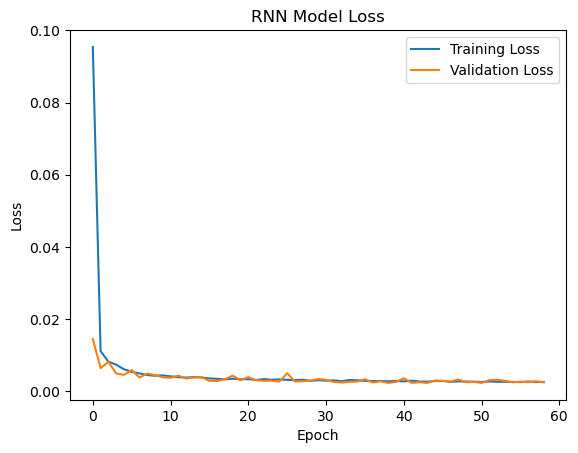

First 5 scaled predictions: [0.41931707 0.4831038  0.30992922 0.4186621  0.4603957 ]
First 5 inverse-transformed predictions: [16.43122  18.185354 13.423054 16.413208 17.560883]


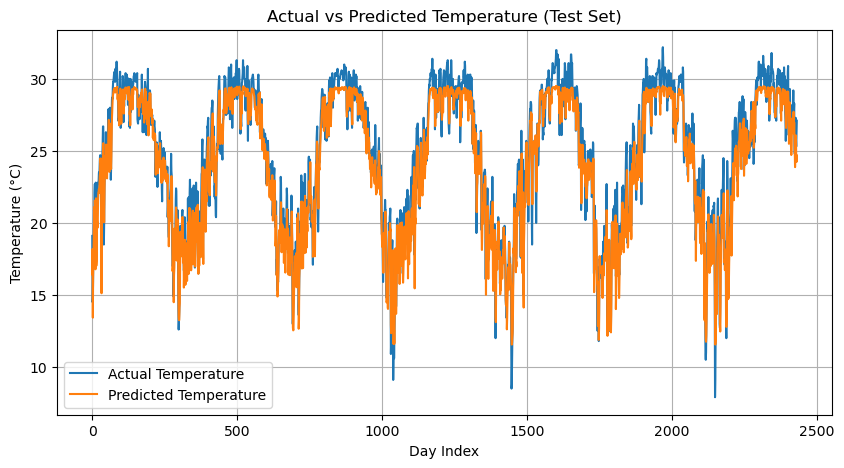

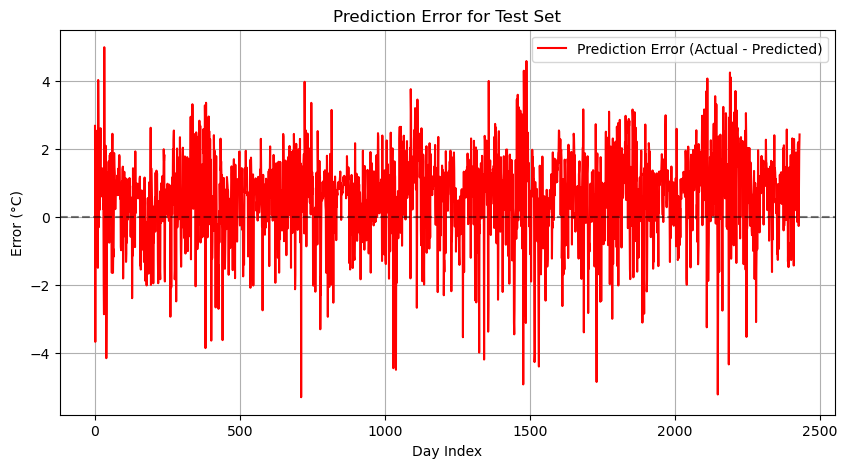

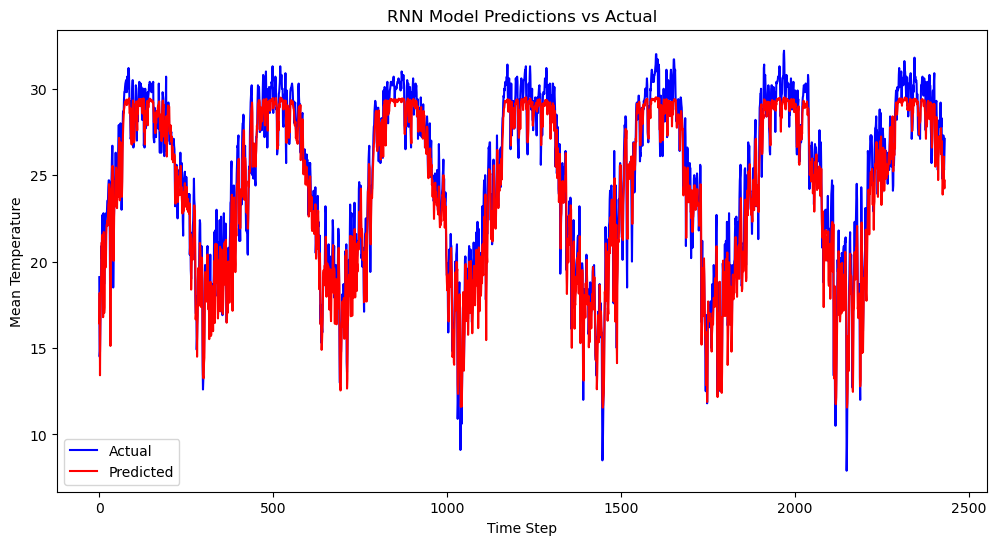

RMSE: 1.3689, MAE: 1.1070


In [96]:
# Initialize the model, loss function, and optimizer
input_size = X.shape[2]
hidden_size = 128
output_size = 1
layer = 3
num_epochs = 100
learning_rate = 0.001

model = EnhancedRNNModel(input_size, hidden_size, output_size, num_layers=layer).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=20, device=device)
# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader, scaler_target)
# Plot the predictions
plot_predictions(predictions, actuals)
# Calculate RMSE and MAE
rmse = math.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

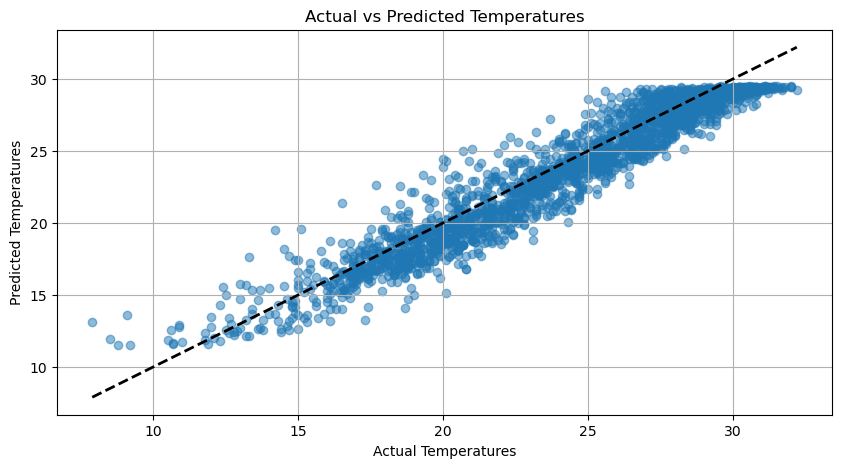

In [97]:
plt.figure(figsize=(10, 5))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2)
plt.title('Actual vs Predicted Temperatures')
plt.xlabel('Actual Temperatures')
plt.ylabel('Predicted Temperatures')
plt.grid(True)
plt.show()